In [1]:
import numpy as np
import math
from matplotlib import pyplot as plt
import random
import pandas as pd
import seaborn as sns

## Implementation of Algorithm

The goal of this function is to implement Lewis' Thinning Algorithm -- generation of arrival events from an inhomogeneous Poisson Process. Suppose the time-varying rate is given by an intensity function $\lambda(t)$ which can be input into our function through an array of tumples Lambda = [(lambda1, t1), (lambda2, t2),...], representing the discrete values $\lambda(t_i)$ for intensity evluated at times $t_1,t_2,...$. T denotes the maximum time we consider for the Poinsson Process. 

In [2]:
def sample_from_exponential_dist(a):
    # random sampling from exponential distribution with mean a
    # we will use inverse sampling 
    u = random.random()
    x = (1/a) * math.log(1/(1-u))
    return x


In [3]:
def inhomogeneousPoisson(Lambda, T):
    '''
    First, we aim to generate an array arrival_times[] representing the arrival time from an homogeneous Poisson Process with 
    fixed rate lambda_max up to time T; meanwhile, we also generate samples from uniform distribution on [0,1] which will decide
    whether these arrival times from homogeneous Poisson Process will be accepted as sample of the inhomogeneous Poisson Process
    '''
    lambda_max = max(Lambda[i][1] for i in range(len(Lambda)))
    
    arrival_times = [0]
    unif_samples = []
    while arrival_times[-1] <= T:
        arrival_times.append(arrival_times[-1]+sample_from_exponential_dist(lambda_max))
        unif_samples.append(random.random())
        
    # take out the first dummy time 0 and the last time which exceeds maximum time T     
    arrival_times = arrival_times[1:-1]
    
    # check if we accept each arrival time in arrival_times[]
    accepted_arrival_times = []
    for i in range(len(arrival_times)):
        # find the rate lambda[t] at the proposed arrival time
        for j in range(len(Lambda)):
            if Lambda[j][0] > arrival_times[i]:
                break
        acceptance_probability = Lambda[j][1]/lambda_max
        if acceptance_probability > unif_samples[i]:
            accepted_arrival_times.append(arrival_times[i])
    
    return accepted_arrival_times

## Testing on toy data set

In [199]:
t = np.linspace(0, 10, 80)

lamb = list(map(math.sin, t[:70]/2))
lamb = [5*(i+1)/2 for i in lamb]

lamb.extend([0]*10)

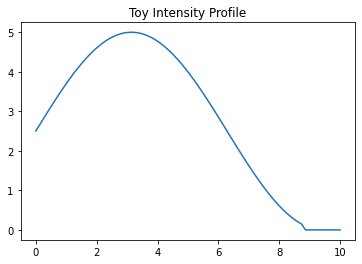

In [200]:
plt.plot(t, lamb)
plt.title('Toy Intensity Profile')
plt.show()

## Plot: Single Experiment

In [201]:
# reshape toy data 
Lambda = list(zip(t,lamb))

Red cross denotes the time when arrival happens. Blue curve is the given intensity function $\lambda(t)$

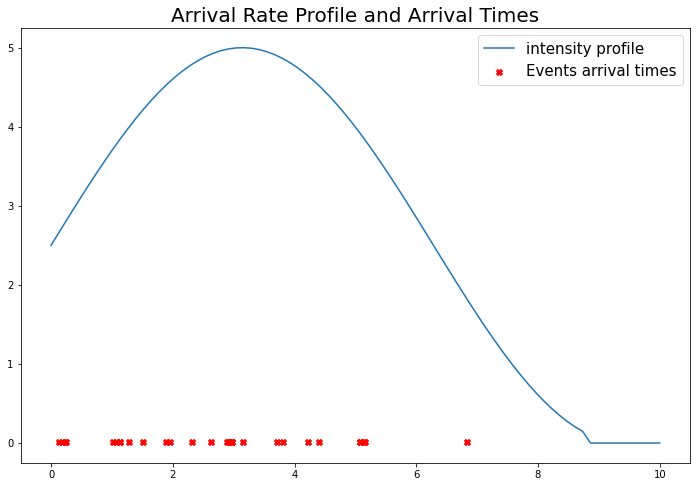

In [244]:
fig, ax = plt.subplots(figsize=(12,8))
t = [L[0] for L in Lambda]
lamb = [L[1] for L in Lambda]
ax.plot(t,lamb,label='intensity profile')
arrival_times = inhomogeneousPoisson(Lambda, 10)
ax.scatter(arrival_times, [0.01]*len(arrival_times), marker='X',c='r', label='Events arrival times')
plt.legend(fontsize=15)
plt.title('Arrival Rate Profile and Arrival Times', fontsize=20)
plt.show()

## Sanity Check

Repeat the experiment for 5000 times and collect all the arrival times. Plot histogram on all arrival times, the curve should
have the same shape as the intensity curve $\lambda(t)$

In [241]:
all_arrival_times = []
repeat = 5000
for _ in range(repeat):
    all_arrival_times.extend(inhomogeneousPoisson(Lambda, 10))

In [242]:
all_arrival_times = pd.DataFrame(all_arrival_times)

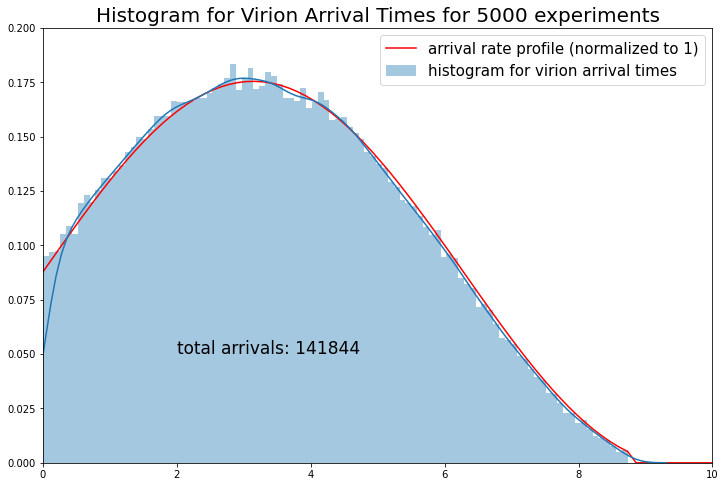

In [243]:
fig, ax = plt.subplots(figsize=(12,8))
x = [L[0] for L in Lambda] 
y = [L[1]/28.5 for L in Lambda]
ax.plot(x, y, color='r', label='arrival rate profile (normalized to 1)')
sns.distplot(all_arrival_times, ax=ax, bins=100,label='histogram for virion arrival times')
plt.xlim(0,10)
plt.ylim(0,0.2)
plt.legend(fontsize=15)
plt.title('Histogram for Virion Arrival Times for '+str(repeat)+' experiments',fontsize=20)
plt.text(2, 0.05, 'total arrivals: '+str(len(all_arrival_times)), fontsize=17)
plt.show()

## Testing on simulated data from PDE model

In [14]:
data = pd.read_excel("E:/projects/CMV/PDE_model_data.xlsx")

In [15]:
time = list(data['time'])
rate = list(data['rate'])

In [16]:
PDE_Lambda = list(zip(time, rate))

In [17]:
PDE_arrival_times = inhomogeneousPoisson(PDE_Lambda, max(time))

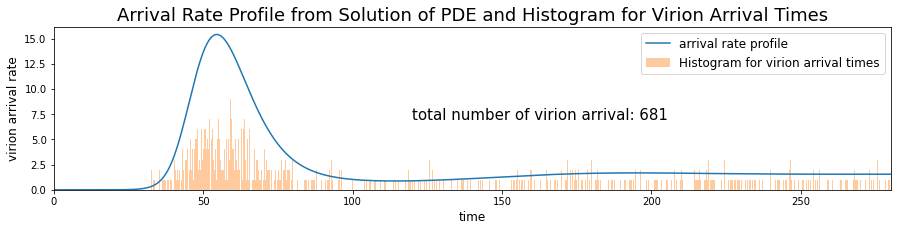

In [18]:
fig, ax = plt.subplots(figsize=(15,3))
ax.plot(time,np.array(rate), label='arrival rate profile')
sns.distplot(PDE_arrival_times,kde=False,bins=840,ax=ax, label='Histogram for virion arrival times')
plt.xlim(0,max(time))
plt.legend(fontsize=12)
plt.title('Arrival Rate Profile from Solution of PDE and Histogram for Virion Arrival Times',fontsize=18)
plt.text(120, 7, 'total number of virion arrival: '+str(len(PDE_arrival_times)),fontsize=15)
plt.xlabel('time',fontsize=12)
plt.ylabel('virion arrival rate',fontsize=12)
plt.show()